In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
from scipy import stats
import math

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, normalize
from sklearn.metrics import r2_score, mean_absolute_error

### Error Functions

In [2]:
def mae_value(X_test,y_test, model, ):
    '''
    return MAE of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)

    #mae
    return mean_absolute_error(y_test, yhat)

def adjusted_r2_value( X_test,y_test,model):
    '''
    return r2 of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    adjusted_r2 = 1 - (1-r2_score(y_test, yhat))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    #adjusted_r2 = 1 - (1-model.score(X_test,y_test))*((len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    
    return adjusted_r2

def r2_value( X_test,y_test,model):
    '''
    return r2 of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    return r2_score(y_test, yhat)

### Plotting and Coefficients

In [3]:
def plot_pred_vs_actual(X_test,y_test, model):
    '''
    plot y prediction against y test
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    #format plot
    plt.rcParams.update({'font.size': 12})    
    plt.title("Predicted VS Actual")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.figure(figsize=(10,5))
    
    #plot 
    plt.scatter(yhat, y_test, alpha=.2, color = '#3468bc')
    plt.plot(np.linspace(0,100000,1000), np.linspace(0,150000,1000))
    x_plot = np.linspace(0, 1, 100)
    
def get_feature_coefs(model,linear,X_train):
    #linear coefs
    if linear:
        print('Feature coefficient results: \n')
        for feature, coef in zip(X_train.columns, model.coef_):
            print(f'Coef of {feature} is : {coef:.2f}')

        return zip(X_train.columns, model.coef_)
    #poly coef
    else:
        print('Feature coefficient results: \n')
        for feature, coef in zip(model.get_feature_names(), model.coef_):
            print( f'Coef of {feature} is : {coef:.2f}')

        return zip(model.get_feature_names(), model.coef_)    

### Regression Functions with Cross Validation

In [16]:
def linear_regression_with_cv(X_train, y_train):
    '''
    print r2 val score and feature coefficient results
    return model
    '''
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    r2_adj = [] #collect the adj val r2 results
    r2_val = [] #collect the val r2 results
    mae_train = [] #collect mae results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X,y):
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #simple linear regression
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        r2_adj.append(round(adjusted_r2_value(X_val, y_val, lm), 3))
        r2_val.append(round(r2_value(X_val, y_val, lm), 3))
        mae_train.append(round(mae_value(X_val, y_val, lm),3))
        
    #report results
    print(f'Simple mean cv adjusted r^2 val score: {np.mean(r2_adj):.3f} +- {np.std(r2_adj):.3f}')
    print(f'Simple mean cv r^2 val score: {np.mean(r2_val):.3f} +- {np.std(r2_val):.3f}')
    print(f'Simple mean cv mae: {np.mean(mae_train):.3f} +- {np.std(mae_train):.3f}')
    
    return lm

def polynomial_regression_with_cv(X_train, y_train, degree, interaction, X_test):
    '''
    print r2 val score and polynomial feature coefficient results
    return model
    '''
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    r2_adj = [] #collect the adj val results
    r2_val = [] #collect the validation results
    mae_train = [] #collect mae results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X,y):
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #create polynomial features
        poly = PolynomialFeatures(degree=degree, interaction_only = interaction)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        
        #fit poly features to linear regression to training data
        lm_poly = LinearRegression()
        lm_poly.fit(X_train_poly, y_train)
        r2_adj.append(round(adjusted_r2_value(X_val_poly, y_val, lm_poly), 3))
        r2_val.append(round(r2_value( X_val_poly,y_val, lm_poly), 3))
        mae_train.append(round(mae_value(X_val_poly,y_val, lm_poly),3))
    
    #get X_test polynomial features
    X_test_poly = poly.transform(X_test)
    
    #report results
    print(f'Results for {degree} degree, interaction_only = {interaction} polynomial regression:')
    print(f'Simple mean cv adjusted r^2 val score: {np.mean(r2_adj):.3f} +- {np.std(r2_adj):.3f}')
    print(f'Simple mean cv r^2 score: {np.mean(r2_val):.3f} +- {np.std(r2_val):.3f}')
    print(f'Simple mean cv mae: {np.mean(mae_train):.3f} +- {np.std(mae_train):.3f}')
    
    return (lm_poly, X_test_poly)

### Scaled Cross Validation Regression

In [5]:
def scaled_linear_regression_with_cv(X_train, y_train, X_test):
    '''
    print val r2 train and r2 train mean 
    return model and scaled X_test
    '''
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    r2_train = [] #collect the validation results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X,y):
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #Feature scaling for train and val
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.values)
        X_val_scaled = scaler.transform(X_val.values)
        
        #simple linear regression
        lm = LinearRegression()
        lm.fit(X_train_scaled, y_train)
        r2_train.append(round(adjusted_r2_value( X_val_scaled,y_val, lm)), 3)
        
    #scale X_test
    X_test_scaled = scaler.transform(X_test.values)
    
    #report results
    print('Simple regression scores: ', r2_train, '\n')
    print(f'Simple mean cv r^2: {np.mean(r2_train):.3f} +- {np.std(r2_train):.3f}')
    
    return (lr_model,X_test_scaled)

### LASSO and RidgeCV

In [6]:
def ridge_cv(folds, alpha_start, alpha_end, alpha_step, X_train, y_train, X_test, y_test):
    '''
    build ridge model, no features discarded and colinear features should have equal weight
    '''
    #scale data
    std = StandardScaler()
    X_train_scaled = std.fit_transform(X_train)
    X_test_scaled = std.transform(X_test)
    
    cv = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=10)
    # define model
    model = RidgeCV(alphas=np.arange(alpha_start, alpha_end, alpha_step), cv=cv, normalize=False)
    # fit model
    model.fit(X_train_scaled, y_train)
    
    print(f'Alpha: {model.alpha_}')
    print(f'MAE value: {mae_value(X_test_scaled, y_test,  model)}')
    print(f'Adjusted r2 test score: {adjusted_r2_value( X_test_scaled,y_test, model)}') 
    print(f'R2 test score: {r2_value( X_test_scaled,y_test, model)}')
    
    return (model, X_test_scaled)

def lasso_cv(folds, alpha_start, alpha_end, alpha_step, X_train, y_train, X_test, y_test):  
    '''
    print optimized alpha of LassoCV val r2 train and r2 train mean 
    return model and scaled X_test
    '''
    #scale data
    std = StandardScaler()
    X_train_scaled = std.fit_transform(X_train)
    X_test_scaled = std.transform(X_test)
    
    cv = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=10)
    # define model
    model = LassoCV(alphas=np.arange(alpha_start, alpha_end, alpha_step), cv=cv, normalize=False)
    # fit model
    model.fit(X_train_scaled, y_train)
    
    print(f'Alpha: {model.alpha_}')
    print(f'MAE value: {mae_value(X_test_scaled, y_test,  model)}')
    print(f'Adjusted r2 test score: {adjusted_r2_value( X_test_scaled,y_test, model)}') 
    print(f'R2 test score: {r2_value( X_test_scaled,y_test, model)}')
    
    return (model, X_test_scaled)

### Load Data

In [7]:
df = pd.read_pickle('../data/model_spec_sales_df.pkl')
# df = df[(np.abs(stats.zscore(df[['Total_Sales','price', 'speed_sec', 'horsepower_hp', 'mpg', 'tank_gal', 'length_in', 
#                                     'width_in', 'height_in','wheelbase_in']])) < 2)] #filtering
#df.drop(labels=['width_in','doors', 'length_in', 'height_in', 'volume_cuft'], axis=1, inplace=True)
df1 = df.loc[:,['Model','Class', 'doors', 'passengers','price', 'speed_sec', 'horsepower_hp', 'drive', 'mpg', 'engine', 'tank_gal',
                'length_in', 'width_in','height_in', 'wheelbase_in', 'Total_Sales']]
df1 = df1.dropna() #drop rows with null values
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1209 entries, 324 to 4438
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Model          1209 non-null   object 
 1   Class          1209 non-null   object 
 2   doors          1209 non-null   object 
 3   passengers     1209 non-null   object 
 4   price          1209 non-null   float64
 5   speed_sec      1209 non-null   float64
 6   horsepower_hp  1209 non-null   float64
 7   drive          1209 non-null   object 
 8   mpg            1209 non-null   float64
 9   engine         1209 non-null   object 
 10  tank_gal       1209 non-null   float64
 11  length_in      1209 non-null   float64
 12  width_in       1209 non-null   float64
 13  height_in      1209 non-null   float64
 14  wheelbase_in   1209 non-null   float64
 15  Total_Sales    1209 non-null   float64
dtypes: float64(10), object(6)
memory usage: 160.6+ KB


In [8]:
#find unique models
df1['Model'].nunique()

301

## EDA

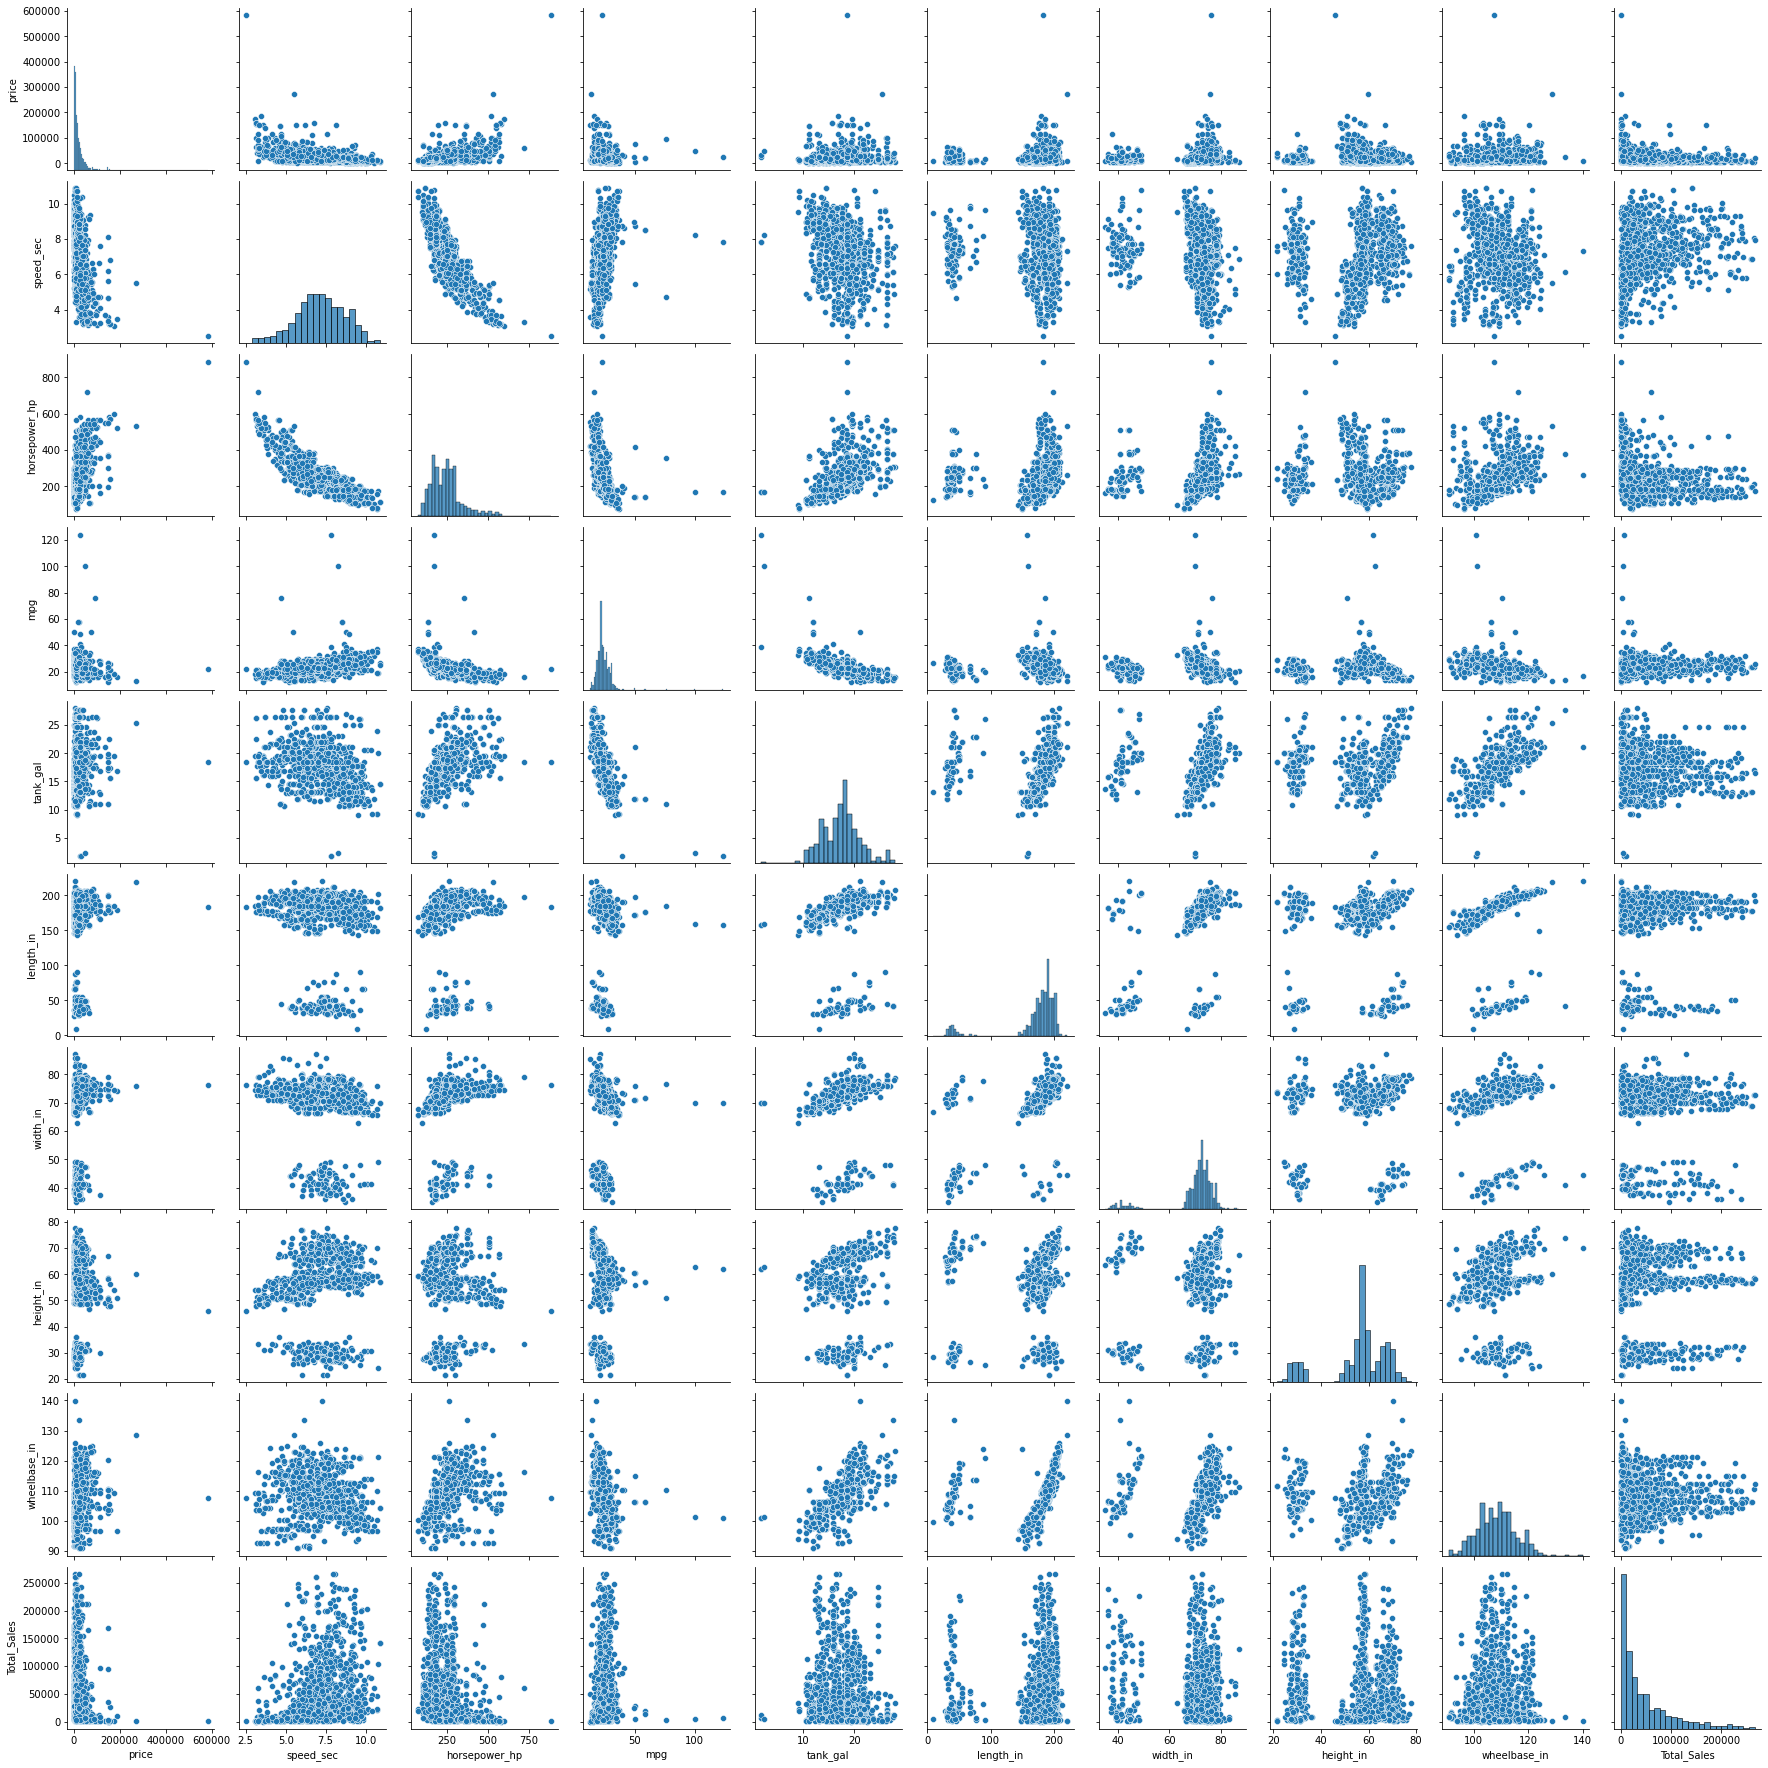

In [9]:
sns.pairplot(df1)

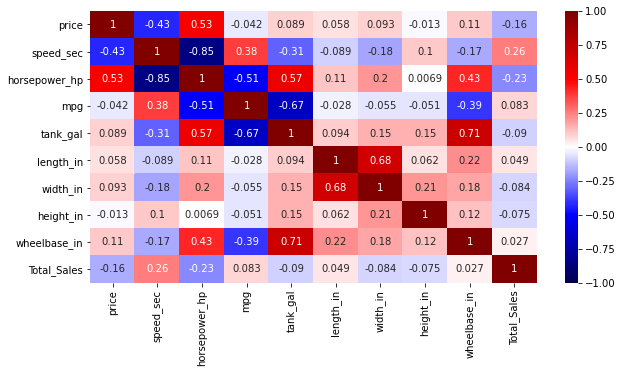

In [10]:
plt.figure(figsize=(10,5))
sns.heatmap(df1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

Check categorical features to see if it is related to Total Sales

<AxesSubplot:xlabel='passengers', ylabel='Count'>

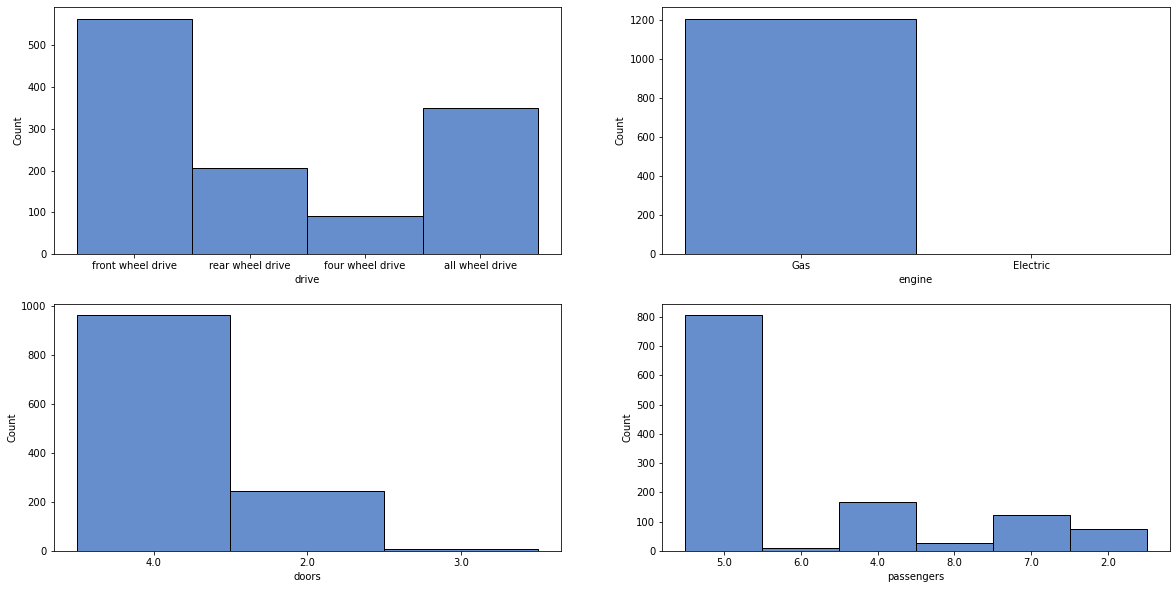

In [11]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2, wspace=0.2)
plt.figure(figsize=(20,10))

ax = plt.subplot(gs[0, 0]) # row 0, col 0
sns.histplot(x=df1['drive'], color = '#3468bc')

ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.histplot(x=df1['engine'], color = '#3468bc')

ax = plt.subplot(gs[1, 0]) # row 0, col 3
sns.histplot(x=df1['doors'], color = '#3468bc')

ax = plt.subplot(gs[1, 1]) # row 0, col 3
sns.histplot(x=df1['passengers'], color = '#3468bc')

#### Intial Takeaways

###### What is the distribution of the target?

##### Are there any colinearities in the feartures?

* Price

##### What are the relationships between each features and the targets

So far there does not appear to be any obvious linear relationships between features and the target

# Modeling

### Baseline Model

define features(X) and Target(y)

In [201]:
X = df1[[ 'doors', 'passengers','price', 'speed_sec', 'horsepower_hp', 'drive', 'mpg', 'engine', 'tank_gal',
                 'length_in', 'width_in','height_in', 'wheelbase_in']]

y = df1['Total_Sales']

#X = pd.get_dummies(X, drop_first=True)
X = pd.get_dummies(X)

split data into train and test data 

In [202]:
# hold out 20% of the data for final testing
#change random state for new subset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

In [203]:
#baseline linear model with cross validation
lm = linear_regression_with_cv(X_train,y_train)

Simple mean cv adjusted r^2 val score: 0.027 +- 0.025
Simple mean cv r^2 val score: 0.149 +- 0.022
Simple mean cv mae: 37783.631 +- 2715.898


In [204]:
#baseline polynomial model with interaction terms only
pm, X_test_pm = polynomial_regression_with_cv(X_train,y_train, 2, True, X_test)

Results for 2 degree, interaction_only = True polynomial regression:
Simple mean cv adjusted r^2 val score: 7.378 +- 2.702
Simple mean cv r^2 score: -2.602 +- 1.518
Simple mean cv mae: 48824.390 +- 6638.333


Severely negative R^2 score for polynomial regression tells us that the model is overfit and that evidence points towards a simple linear regression model.

In [205]:
#baseline lassocv
lasso, X_test_lasso = lasso_cv(5, 600, 700, 1, X_train, y_train, X_test, y_test)
#get coeficients to see if any zeroed out
get_feature_coefs(model=lasso,linear=True,X_train=X_train)

Alpha: 639
MAE value: 37054.88881695007
Adjusted r2 test score: 0.05194782950924948
R2 test score: 0.14635966391496735
Feature coefficient results: 

Coef of price is : -276.74
Coef of speed_sec is : 641.96
Coef of horsepower_hp is : -2263.32
Coef of mpg is : 0.00
Coef of tank_gal is : -6533.93
Coef of length_in is : 3375.18
Coef of width_in is : -2050.19
Coef of height_in is : -4549.93
Coef of wheelbase_in is : 1143.28
Coef of doors_2.0 is : -0.00
Coef of doors_3.0 is : -356.38
Coef of doors_4.0 is : 5285.70
Coef of passengers_2.0 is : -6513.90
Coef of passengers_4.0 is : -6640.75
Coef of passengers_5.0 is : 0.00
Coef of passengers_6.0 is : 637.46
Coef of passengers_7.0 is : 1858.96
Coef of passengers_8.0 is : 8768.29
Coef of drive_all wheel drive is : -2532.87
Coef of drive_four wheel drive is : 2936.60
Coef of drive_front wheel drive is : 4856.55
Coef of drive_rear wheel drive is : -0.00
Coef of engine_Electric is : -970.06
Coef of engine_Gas is : 0.00


MPG is zeroed

In [206]:
#baseline ridgecv
lasso, X_test_ridge = lasso_cv(5, 200, 300, 1, X_train, y_train, X_test, y_test)

Alpha: 299
MAE value: 36831.12499870503
Adjusted r2 test score: 0.0586110618654162
R2 test score: 0.15235933786222122


### Feature Engineering

Split length width and height into smaller and larger catergories

<AxesSubplot:xlabel='height_in', ylabel='Total_Sales'>

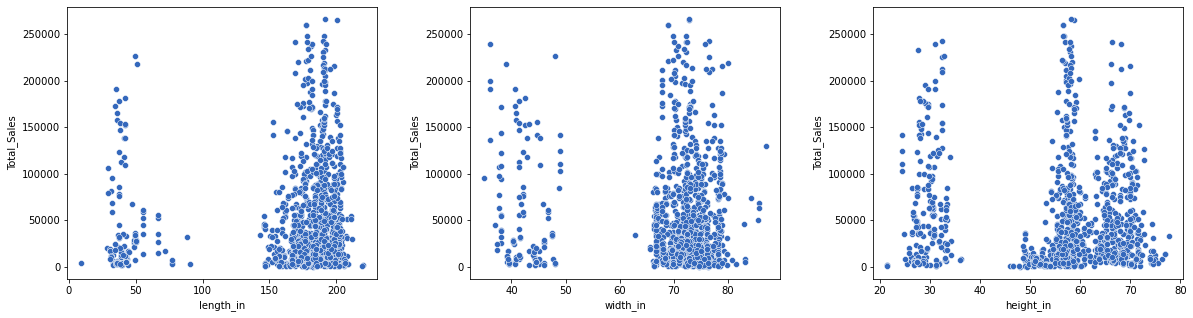

In [207]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 3, wspace=0.3)
plt.figure(figsize=(20,5))

ax = plt.subplot(gs[0, 0]) # row 0, col 0
sns.scatterplot(x = df1['length_in'], y = df1['Total_Sales'], color = '#3468bc')

ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.scatterplot(x=df1['width_in'], y=df1['Total_Sales'], color = '#3468bc')

ax = plt.subplot(gs[0, 2]) # row 0, col 3
sns.scatterplot(x=df1['height_in'], y=df1['Total_Sales'], color = '#3468bc')

In [208]:
#split length by 120 inches
X_train2 = X_train.copy()
X_test2 = X_test.copy()

X_train2['length_low'] = (X_train2['length_in']*(X_train2['length_in']<120))
X_test2['length_low'] = X_test2['length_in']*(X_test2['length_in']<120)

X_train2['length_hi'] = X_train2['length_in']*(X_train2['length_in']>=120)
X_test2['length_hi'] = X_test2['length_in']*(X_test2['length_in']>=120)

#split width by 55 inches
X_train2['width_low'] = (X_train2['width_in']*(X_train2['width_in']<55))
X_test2['width_low'] = (X_test2['width_in']*(X_test2['width_in']<55))

X_train2['width_hi'] = (X_train2['width_in']*(X_train2['width_in']>=55))
X_test2['width_hi'] = (X_test2['width_in']*(X_test2['width_in']>=55))

#split height by 40 inches
X_train2['height_low'] = (X_train2['height_in']*(X_train2['height_in']<40))
X_test2['height_low'] = X_test2['height_in']*(X_test2['height_in']<40)

X_train2['height_hi'] = X_train2['height_in']*(X_train2['height_in']>=40)
X_test2['height_hi'] = X_test2['height_in']*(X_test2['height_in']>=40)

#drop columns
X_train2 = X_train2.drop(labels=['length_in', 'width_in', 'height_in'], axis=1)
X_test2 = X_test2.drop(labels=['length_in', 'width_in', 'height_in'], axis=1)

current_r2 = 0.149
current_adj_r2 = 0.05
print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train2,y_train)
current_r2 = 0.158
current_adj_r2 = 0.044

Current r2 score: 0.149
Current adj r2 score: 0.05
Simple mean cv adjusted r^2 val score: 0.021 +- 0.020
Simple mean cv r^2 val score: 0.158 +- 0.017
Simple mean cv mae: 37487.280 +- 2729.259


Improved r2 but adj r2 went down because more features were added. Lets look at the relationshio between the 6 new columns

<ipython-input-209-544c092ad71e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Total_Sales'] = y_train.copy()


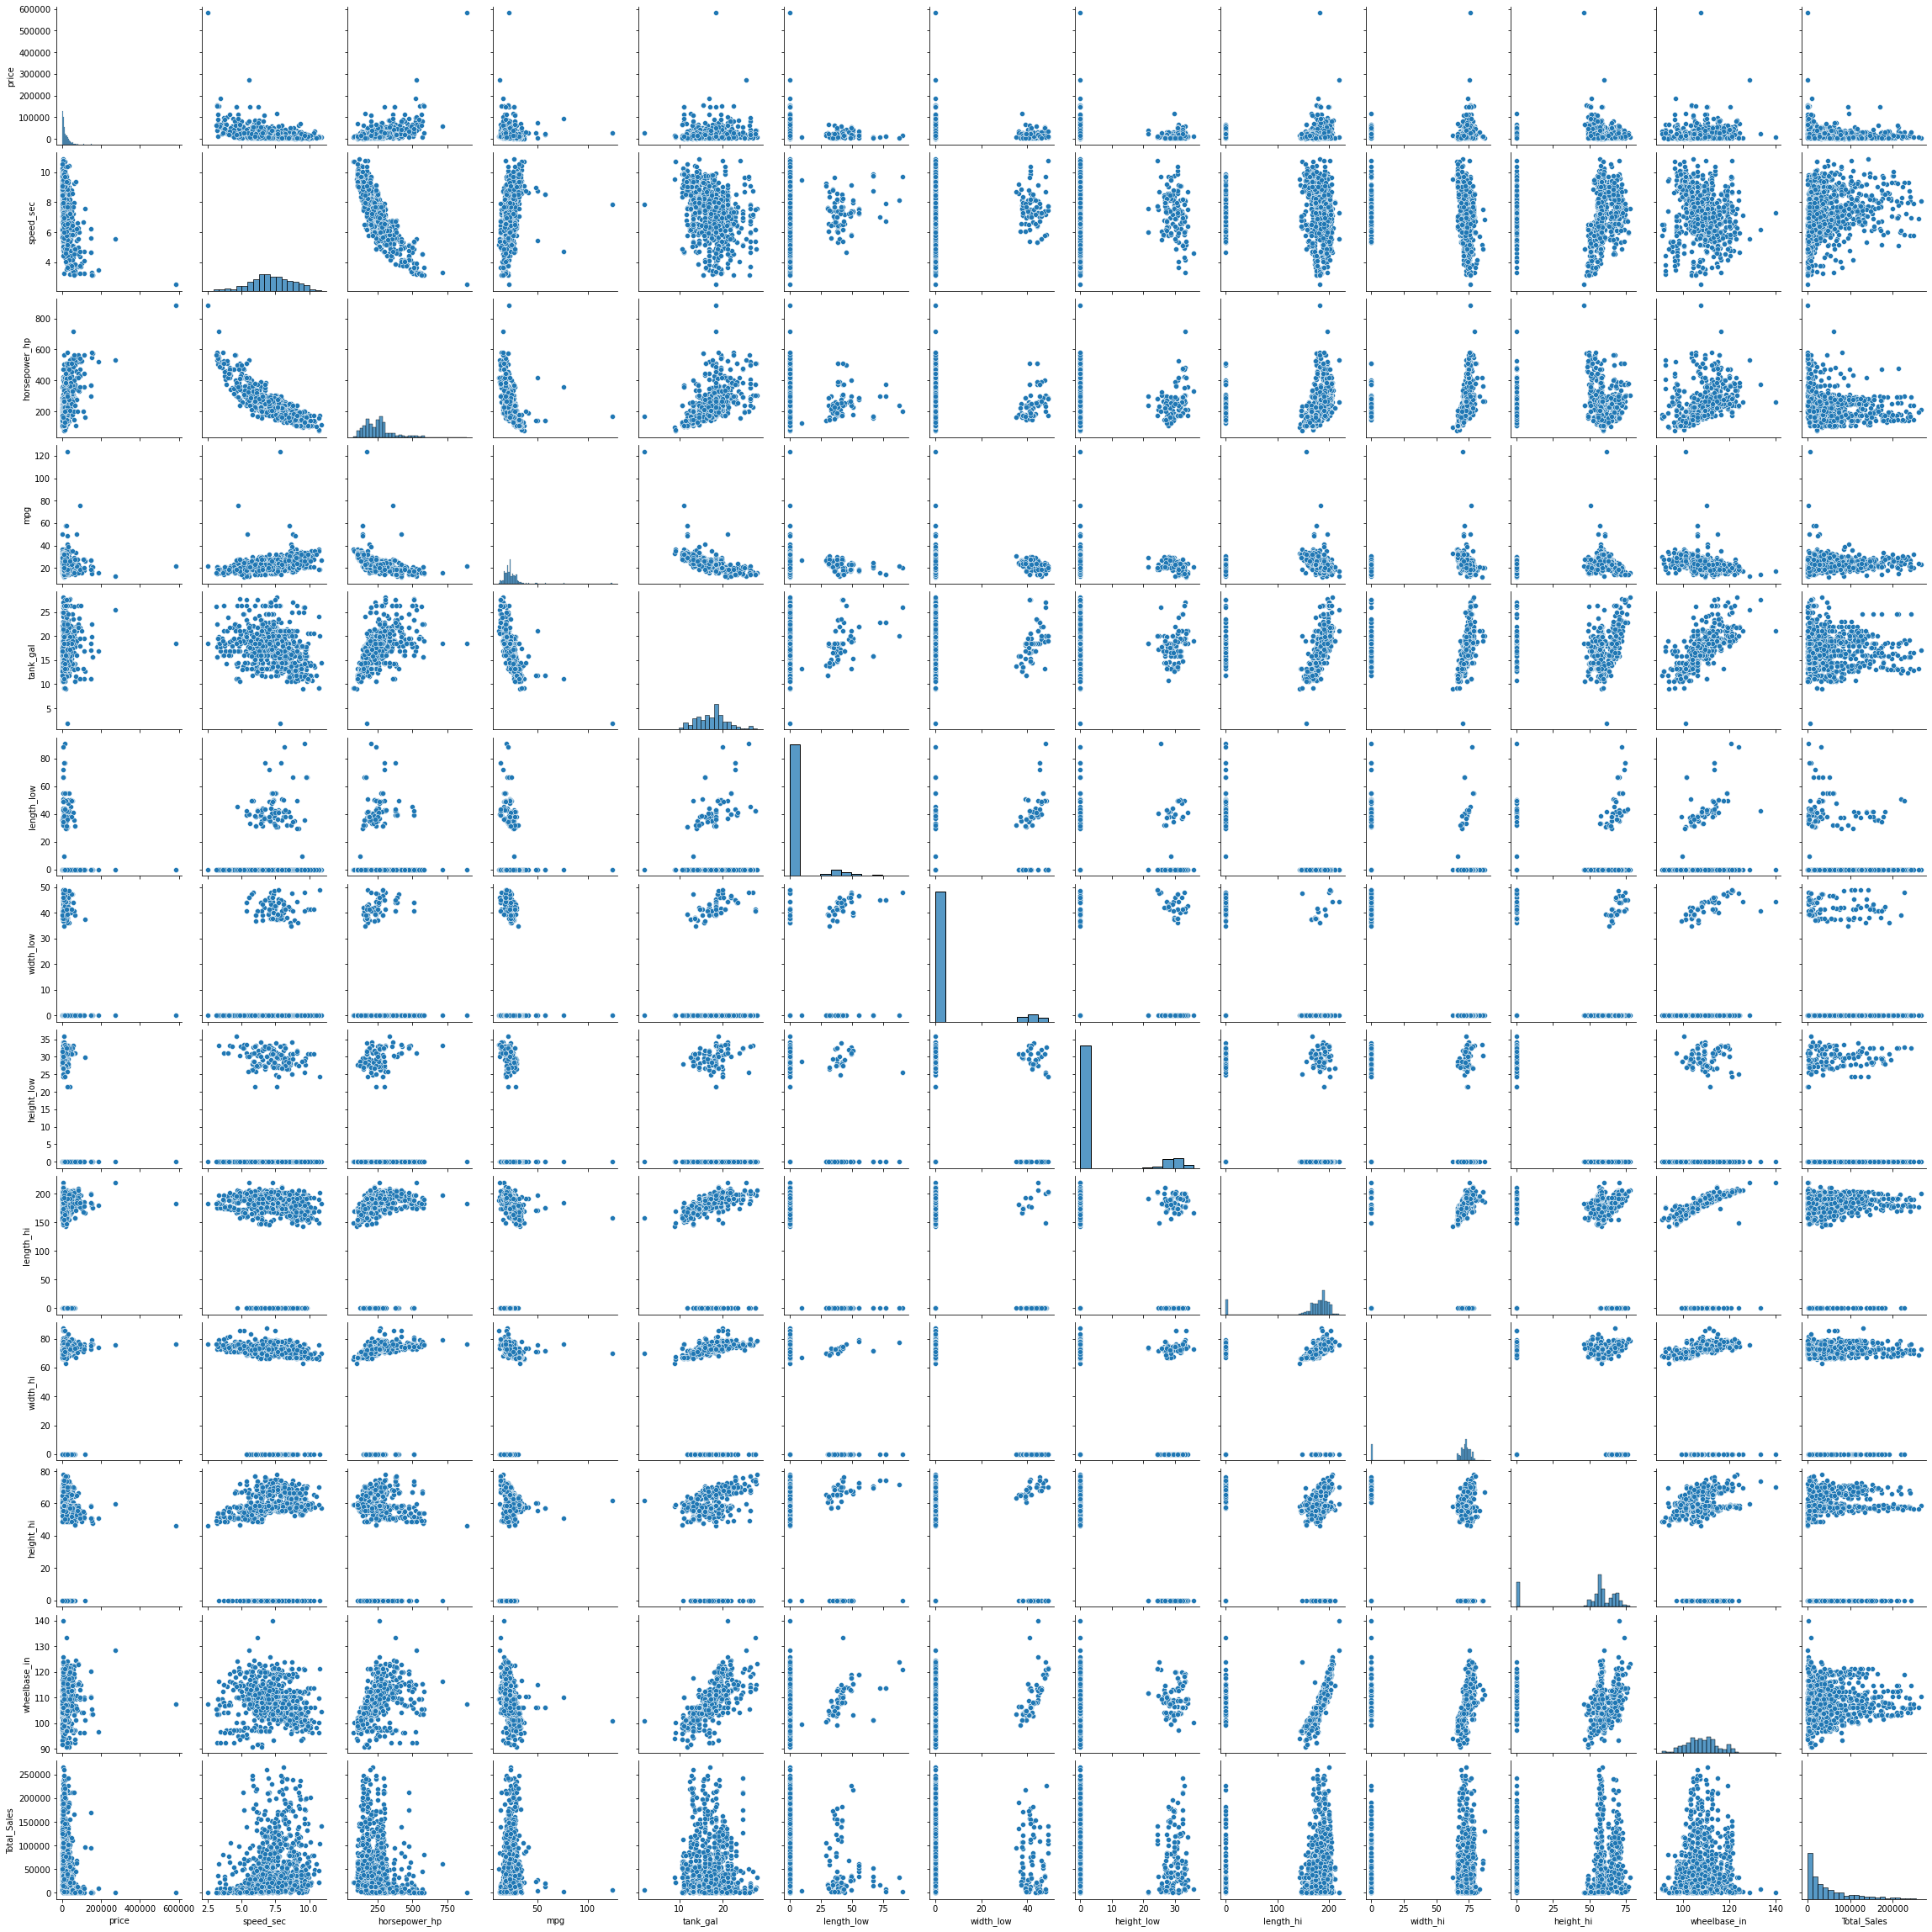

In [209]:
df3 = X_train2[[ 'price', 'speed_sec', 'horsepower_hp', 'mpg',  
                       'tank_gal', 'length_low', 'width_low','height_low', 'length_hi', 'width_hi','height_hi', 
                       'wheelbase_in']]
df3['Total_Sales'] = y_train.copy()
sns.pairplot(df3)

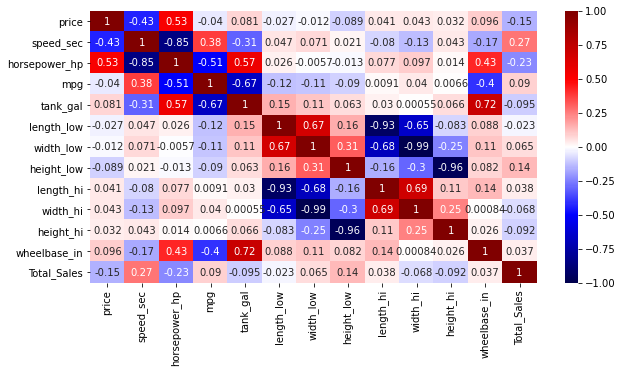

In [210]:
plt.figure(figsize=(10,5))
sns.heatmap(df3.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

* tank_gal and wheel_base are colinear
* width_hi and length_hi are colinear
* width_low and length_low are colinear
* horsepower and tank_gal colinear

In [211]:
#Hi categories and low calories very highly correlated together, multiply and cobine into 2 size categories
X_train3 = X_train2.copy()
X_test3 = X_test2.copy()

X_train3['size_low'] = X_train3['length_low']*X_train3['width_low']*X_train3['height_low']
X_test3['size_low'] = X_test3['length_low']*X_test3['width_low'] *X_test3['height_low']

X_train3['size_hi'] = X_train3['length_hi']*X_train3['width_hi'] *X_train3['height_hi']
X_test3['size_hi'] = X_test3['length_hi']*X_test3['width_hi'] *X_test3['height_hi']

#drop columns
X_train3 = X_train3.drop(labels=['length_hi', 'width_hi', 'height_hi', 'length_low', 'width_low', 'height_low'], axis=1)
X_test3 = X_test3.drop(labels=['length_hi', 'width_hi', 'height_hi', 'length_low', 'width_low', 'height_low'], axis=1)

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train3,y_train)
current_r2 = 0.146
current_adj_r2 = 0.052

Current r2 score: 0.158
Current adj r2 score: 0.044
Simple mean cv adjusted r^2 val score: 0.030 +- 0.009
Simple mean cv r^2 val score: 0.146 +- 0.008
Simple mean cv mae: 38060.793 +- 2315.497


Lowered our adjuested r2 score and made model more simple, but decreased our regular r2 score

<ipython-input-212-d9b16e2573ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Total_Sales'] = y_train.copy()


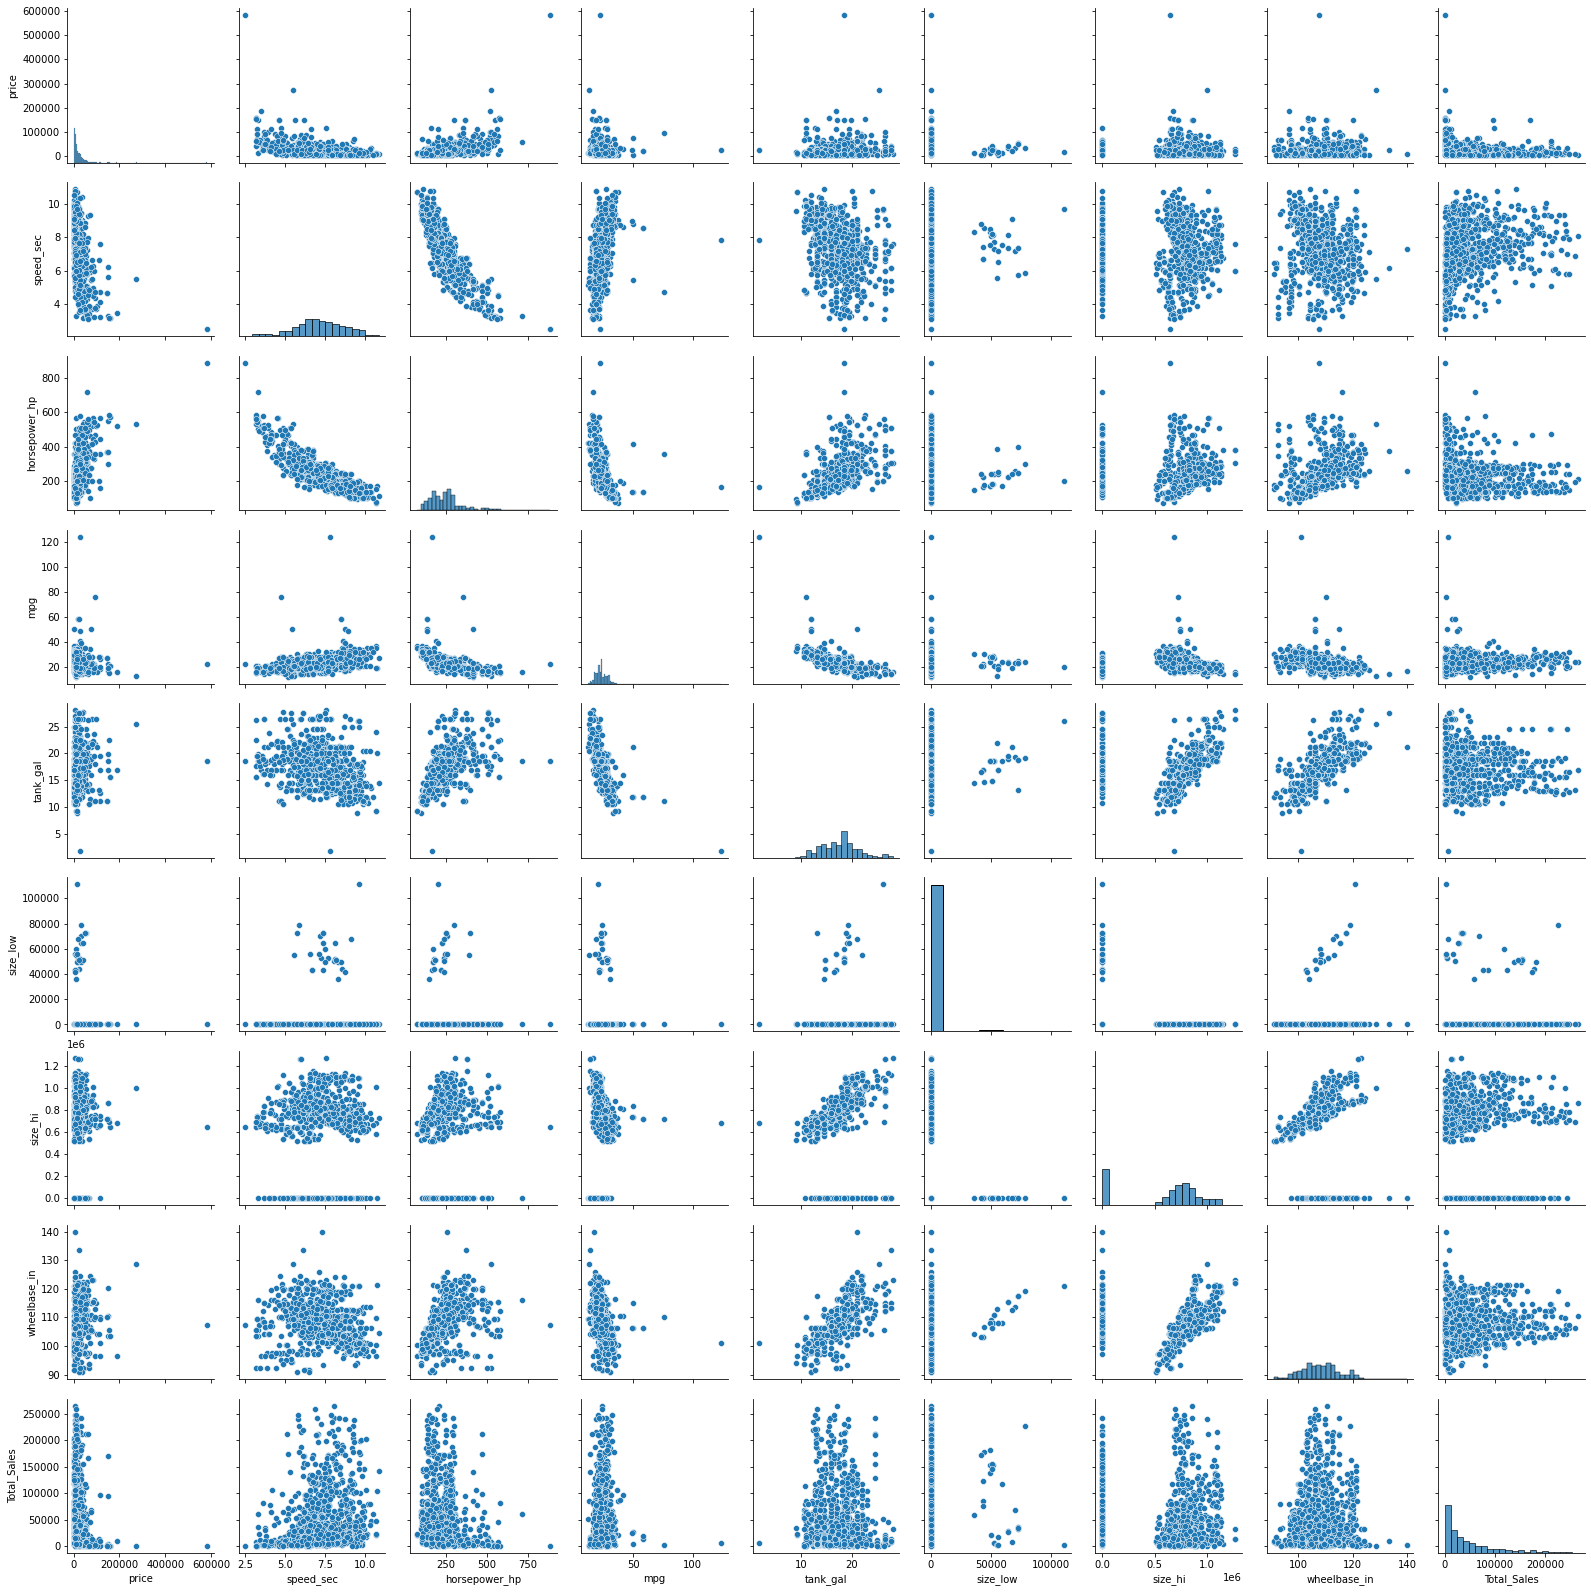

In [212]:
df4 = X_train3[[ 'price', 'speed_sec', 'horsepower_hp', 'mpg',  
                       'tank_gal', 'size_low', 'size_hi',  'wheelbase_in']]
df4['Total_Sales'] = y_train.copy()
sns.pairplot(df4)

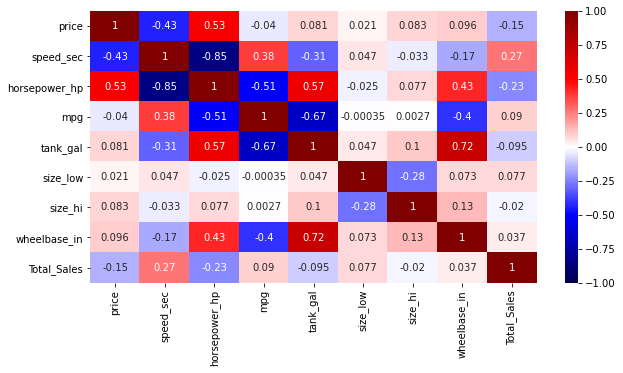

In [213]:
plt.figure(figsize=(10,5))
sns.heatmap(df4.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [228]:
X_train4 = X_train3.copy()
X_test4 = X_test3.copy()

#drop mpg and passengers_4.0 per baseline lassocv model
X_train4 = X_train4.drop(labels=['mpg', 'drive_rear wheel drive', 'engine_Gas', 'doors_2.0',
                                  'passengers_5.0', 'doors_3.0'], axis=1)
X_test4 = X_test4.drop(labels=['mpg', 'drive_rear wheel drive', 'engine_Gas', 'doors_2.0',
                                  'passengers_5.0', 'doors_3.0'], axis=1)

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train4,y_train)
current_r2 = 0.151
current_adj_r2 = 0.068

Current r2 score: 0.151
Current adj r2 score: 0.095
Simple mean cv adjusted r^2 val score: 0.068 +- 0.009
Simple mean cv r^2 val score: 0.151 +- 0.008
Simple mean cv mae: 37980.318 +- 2357.269


Increase in both adjusted r2 and regular r2 val scores when MPG, passengers_4.0, rear whell drive, and doors_3.0 is dropped

In [229]:
#drop wheelbase because it is collinear with tank_gal
X_train4 = X_train4.drop(labels=['wheelbase_in'], axis=1)
X_test4 = X_test4.drop(labels=['wheelbase_in'], axis=1)

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train4,y_train)
current_r2 = 0.149
current_adj_r2 = 0.072

Current r2 score: 0.151
Current adj r2 score: 0.068
Simple mean cv adjusted r^2 val score: 0.072 +- 0.010
Simple mean cv r^2 val score: 0.149 +- 0.009
Simple mean cv mae: 37921.010 +- 2389.580


In [230]:
#drop speed_sec because it is collinear horsepower_hp
X_train4 = X_train4.drop(labels=['speed_sec'], axis=1)
X_test4 = X_test4.drop(labels=['speed_sec'], axis=1)

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train4,y_train)
current_r2 = 0.151
current_adj_r2 = 0.079

Current r2 score: 0.149
Current adj r2 score: 0.072
Simple mean cv adjusted r^2 val score: 0.079 +- 0.012
Simple mean cv r^2 val score: 0.151 +- 0.011
Simple mean cv mae: 37843.392 +- 2402.916


In [231]:
#drop speed_sec because it is collinear horsepower_hp
X_train4 = X_train4.drop(labels=['horsepower_hp'], axis=1)
X_test4 = X_test4.drop(labels=['horsepower_hp'], axis=1)

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train4,y_train)
current_r2 = 0.152
current_adj_r2 = 0.086

Current r2 score: 0.151
Current adj r2 score: 0.079
Simple mean cv adjusted r^2 val score: 0.086 +- 0.013
Simple mean cv r^2 val score: 0.152 +- 0.012
Simple mean cv mae: 37781.707 +- 2406.755


Regular r2 value stayed the same and adjusted r2 increased after the 2 columns were dropped. 

<ipython-input-232-ff64eff7ecb4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['Total_Sales'] = y_train.copy()


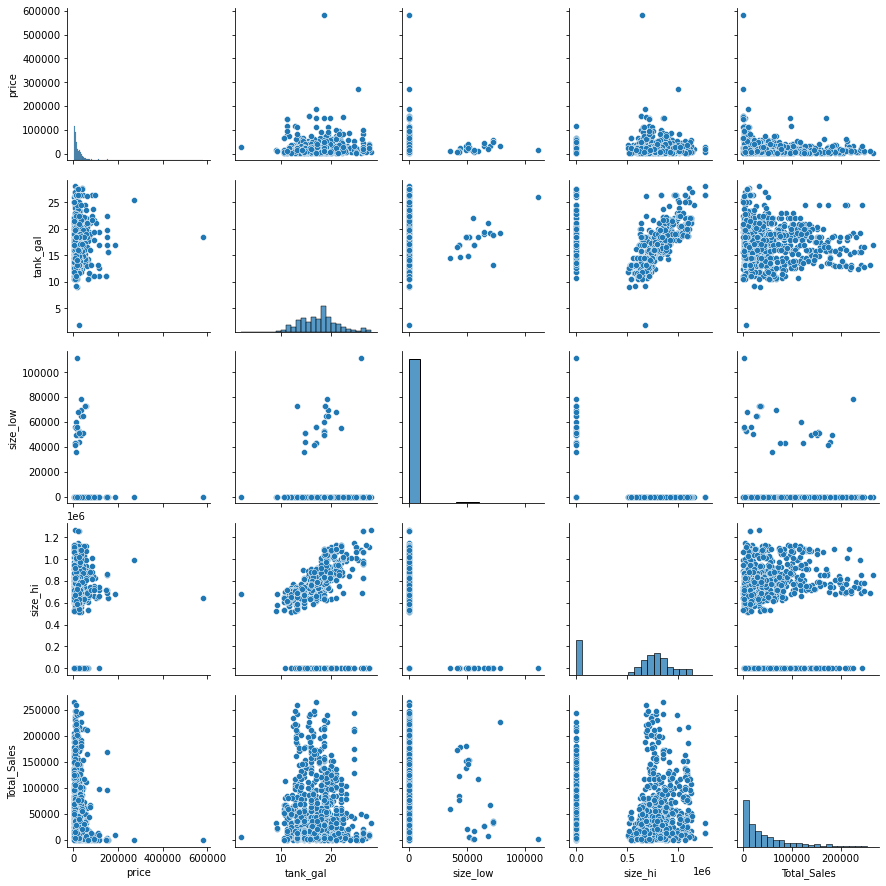

In [232]:
df5 = X_train4[[ 'price', 'tank_gal', 'size_low', 'size_hi']]
#df5 = X_train4
df5['Total_Sales'] = y_train.copy()
sns.pairplot(df5)

Perform BoxCox transformation on non-normally distributed features

In [234]:
X_train5 = X_train4.copy()
X_test5 = X_test4.copy()

# transform price feature into normal distribution data & save lambda value 
fitted_train_data, fitted_train_lambda = stats.boxcox(X_train5['price']) 
fitted_test_data, fitted_test_lambda = stats.boxcox(X_test5['price']) 
X_train5['price'] = np.log(fitted_train_data)
X_test5['price'] = fitted_test_data

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train5,y_train)
current_r2 = 0.153
current_adj_r2 = 0.087

Current r2 score: 0.153
Current adj r2 score: 0.097
Simple mean cv adjusted r^2 val score: 0.087 +- 0.010
Simple mean cv r^2 val score: 0.153 +- 0.010
Simple mean cv mae: 37751.904 +- 2473.960


<ipython-input-235-47e71262137e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['Total_Sales'] = y_train.copy()


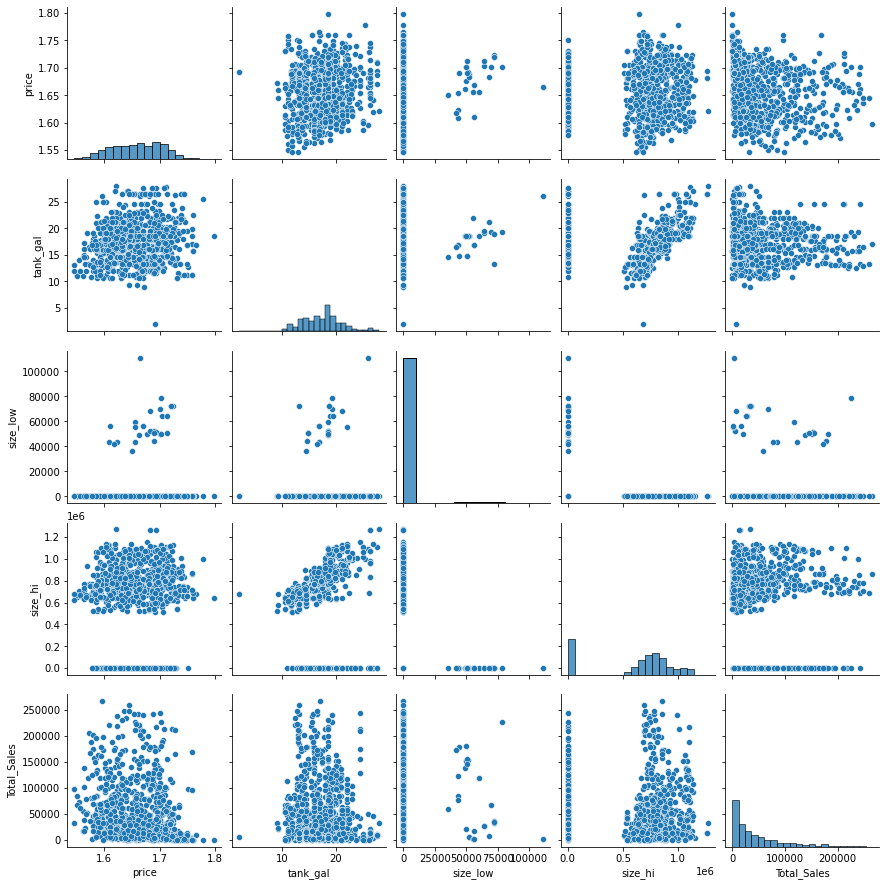

In [235]:
df6 = X_train5[[ 'price', 'tank_gal', 'size_low', 'size_hi']]
df6['Total_Sales'] = y_train.copy()
sns.pairplot(df6)

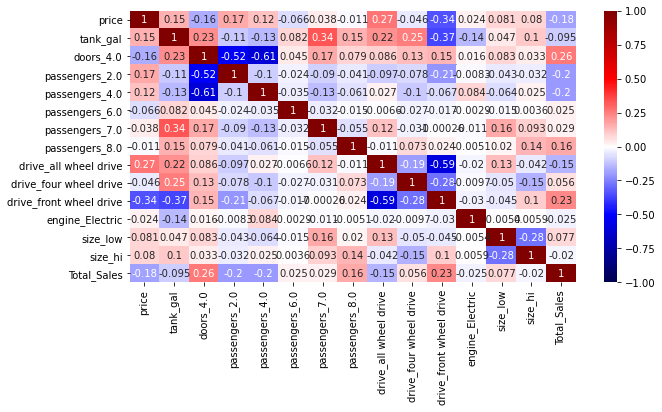

In [236]:
df7 = X_train5
df7['Total_Sales'] = y_train.copy()
plt.figure(figsize=(10,5))
sns.heatmap(df7.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [239]:
X_train6 = X_train5.copy()
X_test6 = X_test5.copy()

#Insert interaction terms for price
#X_train6['price*4d'] = X_train6['price']*X_train6['doors_4.0']

print(f'Current r2 score: {current_r2}')
print(f'Current adj r2 score: {current_adj_r2}')
lm2 = linear_regression_with_cv(X_train6,y_train)
current_r2 = 0.153
current_adj_r2 = 0.087

Current r2 score: 0.153
Current adj r2 score: 0.087
Simple mean cv adjusted r^2 val score: 1.000 +- 0.000
Simple mean cv r^2 val score: 1.000 +- 0.000
Simple mean cv mae: 0.000 +- 0.000


In [139]:
#create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only = True)
X_train_poly = poly.fit_transform(X_train5)
X_test_poly = poly.transform(X_test5)
lasso_cv(10, 100, 200, 1, X_train_poly, y_train, X_test_poly, y_test) 

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1158716935.440918, tolerance: 266426359.90646675
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1138516487.4987793, tolerance: 266426359.90646675
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1125422946.7392578, tolerance: 266426359.90646675
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1211482740.0673828, tolerance: 268253321.82701242
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1195091623.788086, tolerance: 268253321.82701242
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1182239370.0681152, tolerance: 268253321.82701242
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336585669.36621094, tolerance: 264189956.43744382
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 953386486.3710938, tolerance: 265040731.45438406
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1187688882.0170898, tolerance: 272806438.7102961
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1197218309.8483887, tolerance: 270893604.5960852
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1184586165.0322266, tolerance: 270893604.5960852
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1172102338.2106934, tolerance: 270893604.5960852
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1169889010.407959, tolerance: 269760150.55880105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1150905308.4394531, tolerance: 269760150.55880105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1139985811.7763672, tolerance: 269760150.55880105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/racheldilley/opt/anaconda

Alpha: 100
MAE value: 51068.86729011854
Adjusted r2 test score: -1.0577476995977264
R2 test score: -0.15268024666262692


/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1171360503.0449219, tolerance: 296924503.8114792
  model = cd_fast.enet_coordinate_descent(


(LassoCV(alphas=array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
        178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
        191, 192, 193, 194, 195, 196, 197, 198, 199]),
         cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=10)),
 array([[ 0.        , -6.03285415,  0.65845672, ..., -0.1669285 ,
          0.71839371,  0.        ],
        [ 0.        , -5.68336469,  0.65845672, ..., -0.1669285 ,
          0.74944664,  0.        ],
        [ 0.        , -6.10361257,  0.57458849, ..., -0.1669285 ,
         -1.66968849,  0.        ],
        ...,
        [ 0.        , -6.1692

In [ ]:
X_train5['tank_mpg'] = (X_train5['tank_gal'])*(X_train5['mpg'])*(X_train5['wheelbase_in'])
# X_train5['speed_log'] = np.log(X_train5['speed_sec'])
X_train5 = X_train5.drop(labels=['tank_gal'], axis=1)
X_train5 = X_train5.drop(labels=['mpg'], axis=1)
X_train5 = X_train5.drop(labels=['horsepower_hp'], axis=1)

X_test5['speed_hp'] = (X_test5['speed_sec'])*(X_test5['horsepower_hp'])
X_test5 = X_test5.drop(labels=['speed_sec'], axis=1)
X_test5 = X_test5.drop(labels=['horsepower_hp'], axis=1)
X_train5 = X_train5.drop(labels=['wheelbase_in'], axis=1)
# #X_test5 = X_test5.drop(labels=['speed_sec'], axis=1)

X_test5['tank_mpg'] = (X_test5['tank_gal'])*(X_test5['mpg'])*(X_test5['wheelbase_in'])
X_test5 = X_test5.drop(labels=['tank_gal'], axis=1)
X_test5 = X_test5.drop(labels=['mpg'], axis=1)
X_test5 = X_test5.drop(labels=['wheelbase_in'], axis=1)

simple_linear_regression(X_train5,y_train)
# print(max_r2)
# #sns.scatterplot(x='Log(Followers)', y='Popularity', data=df_hiphop_feature_eng)

# sns.scatterplot(X_train5['speed_log'], y_train)
# max_r2 = 0.19441360490547865

In [ ]:
#add non linear relationship for speed
X_train6 = X_train5.copy()
X_test6 = X_test5.copy()

# #X_train4['speed_4sqr'] = 0.25**X_train4['speed_sec']
# X_train6['mpg_sqr'] = X_train6['mpg']**2

# #X_train4 = X_train4.drop(labels=['speed_sec'], axis=1)

# X_test6['mpg_sqr'] = X_test6['mpg']**2
# #X_test4 = X_test4.drop(labels=['speed_sec'], axis=1)

# simple_linear_regression(X_train6,y_train)
# print(max_r2)
# #sns.scatterplot(x='Log(Followers)', y='Popularity', data=df_hiphop_feature_eng)
# sns.scatterplot(X_train6['mpg_sqr'], y_train)

# max_r2 = 0.20608026091337384

In [ ]:
#add non linear relationship for speed
# X_train5 = X_train.copy()
# #X_train4['speed_sq'] = X_train4['speed_sec']**3 - X_train4['speed_sec']
# #X_train4 = X_train4.drop(labels=['speed_sec'], axis=1)
# simple_linear_regression(X_train4,y_train)
# print(max_r2)

In [ ]:
model = simple_linear_regression(X_train5,y_train)
mae = mae_value_plot(X_test5,y_test, model)
print(r2_value( X_test5,y_test, model), mae)

In [ ]:
model = scaled_linear_regression(X_train4,y_train)
mae = mae_value_plot(X_test4,y_test, model)
print(r2_value( X_test4,y_test, model), mae)

LassoCV

In [ ]:
lasso_reg(10, 100, 200, 1, X_train5, y_train, X_test5, y_test) 

In [ ]:
polynomial_lasso_reg(10, 300, 400, 1, X_train4, y_train, X_test4, y_test) 


In [ ]:
alpha = 791
mae = 34481.79189953941
r2 = 0.2401656496992064

In [ ]:
polynomial_lasso_reg(10, 700, 800, 1, X_train4, y_train, X_test4, y_test) 